# SIR epidemic model - [sensitivity analysis]

In this notebook we will understand SIR epidemic model - its equations and parameters. 
Then we will perform sensitivity analysis of those parameters (with theoretical introduction).

## SIR model

`SIR` model describes dynamics of an epidemic for fixed numer of individuals (`N`) and given contact/infection rate together with mean recovery rate.  
Our population is comprised of three groups: 
- `S` - Suspected
- `I` - Infected
- `R` - Recovered 

There's also a variant that includes those who had contact with infected person but haven't developed symptoms yet (`SEIR` with `E` - Exposed), and another variant with $\alpha$ representing death rate caused by epidemic (coupled in $\gamma+\alpha$) and separate group `D` for deaths (`SIRD`).

In `SIR` model where epidemic occurs in relatively short period of time we neglect birth rate and death rate (counting only non-epidemic deaths) in considered group. So we end up with two parameters: 
- $\beta$ - contact rate (infected contacts $\beta N$ other individuals per time step)
- $\gamma$ - mean recovery rate ($1/\gamma$ days that recovery takes on average)

<img src="https://i.ibb.co/XSgYy7w/Screenshot-2020-10-31-The-SIR-epidemic-model.png" width="400">

At the end we will be interested in calculating reproduction ratio: 
$$R_0=\frac{\beta}{\gamma}$$
that will determine wheter the pandemic is in retreat ($R_0 < 1$) or in advance ($R_0 > 1$)

Model is described with given differential equations:

\begin{align}
\frac{dS}{dt} & = -\frac{\beta SI}{N}\\
\frac{dI}{dt} & = \frac{\beta SI}{N} - \gamma I \\
\frac{dR}{dt} & = \gamma I
\end{align}

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
assert tf.__version__[0] == '2', 'Tensorflow 2.x version required'

In [3]:
np.random.seed(2)
tf.random.set_seed(2)

### Task 1: Complete equations according to formulas

In [4]:
def deriv(y, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

## Euler scheme

Euler scheme is a numerical procedure for integrating systems of differential equations which we will be using to solve SIR for our parameters.  
We're looking for a solution $y(t)$ given $y'(t)=f(t,y(t))$ dynamics together with initial conditions $y(t_0)=y_0$.  

With defined step size $h$ that $t_{n+1}=t_n+h$ we have formula:

$$y_{n+1}=y_n+hf(t_n,y_n)$$

### Task 2: Complete the formula for each component

In [5]:
def euler(deriv, y0, dt, steps, N, beta, gamma):
    S0, I0, R0 = y0
    S_result, I_result, R_result = S0, I0, R0
    for i in range(steps-1):
        S1, I1, R1 = deriv((S0, I0, R0), N, beta, gamma)
        next_s, next_i, next_r = S0 + dt*S1, I0 + dt*I1, R0 + dt*R1
        S_result = tf.concat([S_result, next_s], axis=0)
        I_result = tf.concat([I_result, next_i], axis=0)
        R_result = tf.concat([R_result, next_r], axis=0)
        S0, I0, R0 = next_s, next_i, next_r
    return S_result, I_result, R_result

## Example run

In [6]:
# Total population
N = tf.constant([1000.])

# Initial infected and recovered individuals
I0, R0 = tf.constant([1.]), tf.constant([0.])

# Everyone else, S0, is susceptible to infection initially
S0 = N - I0 - R0

# Initial conditions tuple
y0 = S0, I0, R0

# Contact rate (beta), and mean recovery rate (gamma), (in 1/days)
beta, gamma = 0.4, 1./10

# A grid of time points (in days)
days = 160
t = np.linspace(0, days, days)
dt = 1.

### Task 3: Solve with euler scheme

In [7]:
S, I, R = euler(deriv, y0, dt, days, N, beta, gamma)

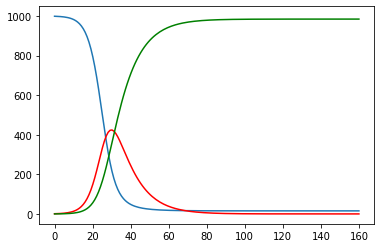

In [8]:
fig, ax = plt.subplots()
ax.plot(t, S)
ax.plot(t, I, color='r')
ax.plot(t, R, color='g')
plt.show()

## Sensitivity analysis

In sensitivity analysis we are interested in understanding how minor changes in input space contribute to output results for our black-box model defined as a continous scalar function $\phi: \mathbb{R}^p \to \mathbb{R}$.  

Sensitivity analysis methods help us identify influential paremeters. There are global SA methods that compute sensitivity for whole input space, and local SA methods that perform it for given subarea. Both are widely used in physics, finance and engineering. 

### Global SA

Global methods compute indices considering whole input spaces. Example of global method is Sobol Method (also referred as Variance-based sensitivity analysis) which decomposes output variance into orthogonal terms that are used to compute e.g. first-order sensitivity indices.

(https://en.wikipedia.org/wiki/Variance-based_sensitivity_analysis)

Estimates are computed with generated samples - whole process can be performed with SALib python library.

### Local SA

In local methods we do SA for given point in input space. To expand it for whole input space we heve e.g. Morris Method (global method) that performs a walk through input space and averages results.
Here we will be implementing:
- finite differences method (central difference estimator variant):

$$\Delta_C = \frac{Y(\theta + h) - Y(\theta - h)}{2h}$$

- adjoint method:

$$\Delta = \frac{\partial Y}{\partial \beta}(t, \beta, \gamma)$$

We will perform forward solve and then backpropagate through solver.

In [9]:
def model_I(deriv, y0, dt, steps, N, beta, gamma):
    _, I, _ = euler(deriv, y0, dt, steps, N, beta, gamma)
    return I[:,None,None]

In [10]:
h = 0.001
beta, gamma = tf.constant([0.4]), 1./10

### Task 4: Implement finite difference method (central variant)

In [11]:
res1 = model_I(deriv, y0, dt, days, N, beta + h, gamma)
res2 = model_I(deriv, y0, dt, days, N, beta - h, gamma)

(tf.reduce_sum(res1) - tf.reduce_sum(res2)) / (2.0*h)

<tf.Tensor: shape=(), dtype=float32, numpy=1912.5975>

In [12]:
with tf.GradientTape() as g:
    g.watch(beta)
    I = model_I(deriv, y0, dt, days, N, beta, gamma)
dI_dbeta = g.gradient(I, beta)

In [13]:
dI_dbeta[0]

<tf.Tensor: shape=(), dtype=float32, numpy=1911.5173>

### Task 5: Create plot for deltas for whole beta range

In [14]:
deltas = []
space = np.linspace(0.0, 0.4, 50)
for beta in space:
    beta = tf.constant([beta], dtype=tf.float32)
    with tf.GradientTape() as g:
        g.watch(beta)
        I = model_I(deriv, y0, dt, days, N, beta, gamma)
    dI_dβ = g.gradient(I, beta)[0].numpy()
    deltas.append(dI_dβ)

Text(0.5, 0, 'beta')

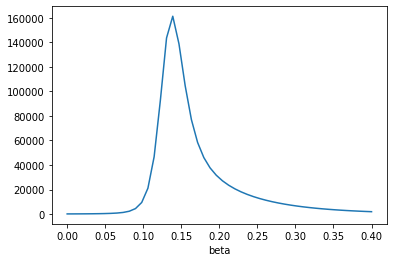

In [15]:
fig, ax = plt.subplots()
ax.plot(space, deltas)
plt.xlabel('beta')

## SALib

`SALib` provides us with global sensitivity methods. Here we will use Sobol Analysis method.

In [16]:
from SALib.sample import saltelli
from SALib.analyze import sobol

In [17]:
problem = {
    'num_vars': 2,
    'names': ['beta', 'gamma'],
    'bounds': [[0.0, 0.4], [1./18, 1./8]]
}

In [18]:
param_values = saltelli.sample(problem, 100, calc_second_order=False)

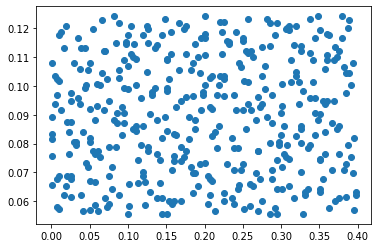

In [19]:
plt.scatter(param_values[:,0], param_values[:,1])

In [20]:
Y = np.zeros([param_values.shape[0]])

for i, (beta, gamma) in enumerate(param_values):
    Y[i] = tf.reduce_sum(model_I(deriv, y0, dt, days, N, beta, gamma))

In [21]:
Si = sobol.analyze(problem, Y, calc_second_order=False)

In [22]:
Si

{'S1': array([0.7475557 , 0.16852292]),
 'S1_conf': array([0.19277332, 0.14673407]),
 'ST': array([0.89294114, 0.26704384]),
 'ST_conf': array([0.22591018, 0.08714372])}